# Лабораторная работа №5

### Вариант 9

[0.         0.03173326 0.06346652 0.09519978 0.12693304 0.1586663
 0.19039955 0.22213281 0.25386607 0.28559933 0.31733259 0.34906585
 0.38079911 0.41253237 0.44426563 0.47599889 0.50773215 0.53946541
 0.57119866 0.60293192 0.63466518 0.66639844 0.6981317  0.72986496
 0.76159822 0.79333148 0.82506474 0.856798   0.88853126 0.92026451
 0.95199777 0.98373103 1.01546429 1.04719755 1.07893081 1.11066407
 1.14239733 1.17413059 1.20586385 1.23759711 1.26933037 1.30106362
 1.33279688 1.36453014 1.3962634  1.42799666 1.45972992 1.49146318
 1.52319644 1.5549297  1.58666296 1.61839622 1.65012947 1.68186273
 1.71359599 1.74532925 1.77706251 1.80879577 1.84052903 1.87226229
 1.90399555 1.93572881 1.96746207 1.99919533 2.03092858 2.06266184
 2.0943951  2.12612836 2.15786162 2.18959488 2.22132814 2.2530614
 2.28479466 2.31652792 2.34826118 2.37999443 2.41172769 2.44346095
 2.47519421 2.50692747 2.53866073 2.57039399 2.60212725 2.63386051
 2.66559377 2.69732703 2.72906028 2.76079354 2.7925268  2.824260

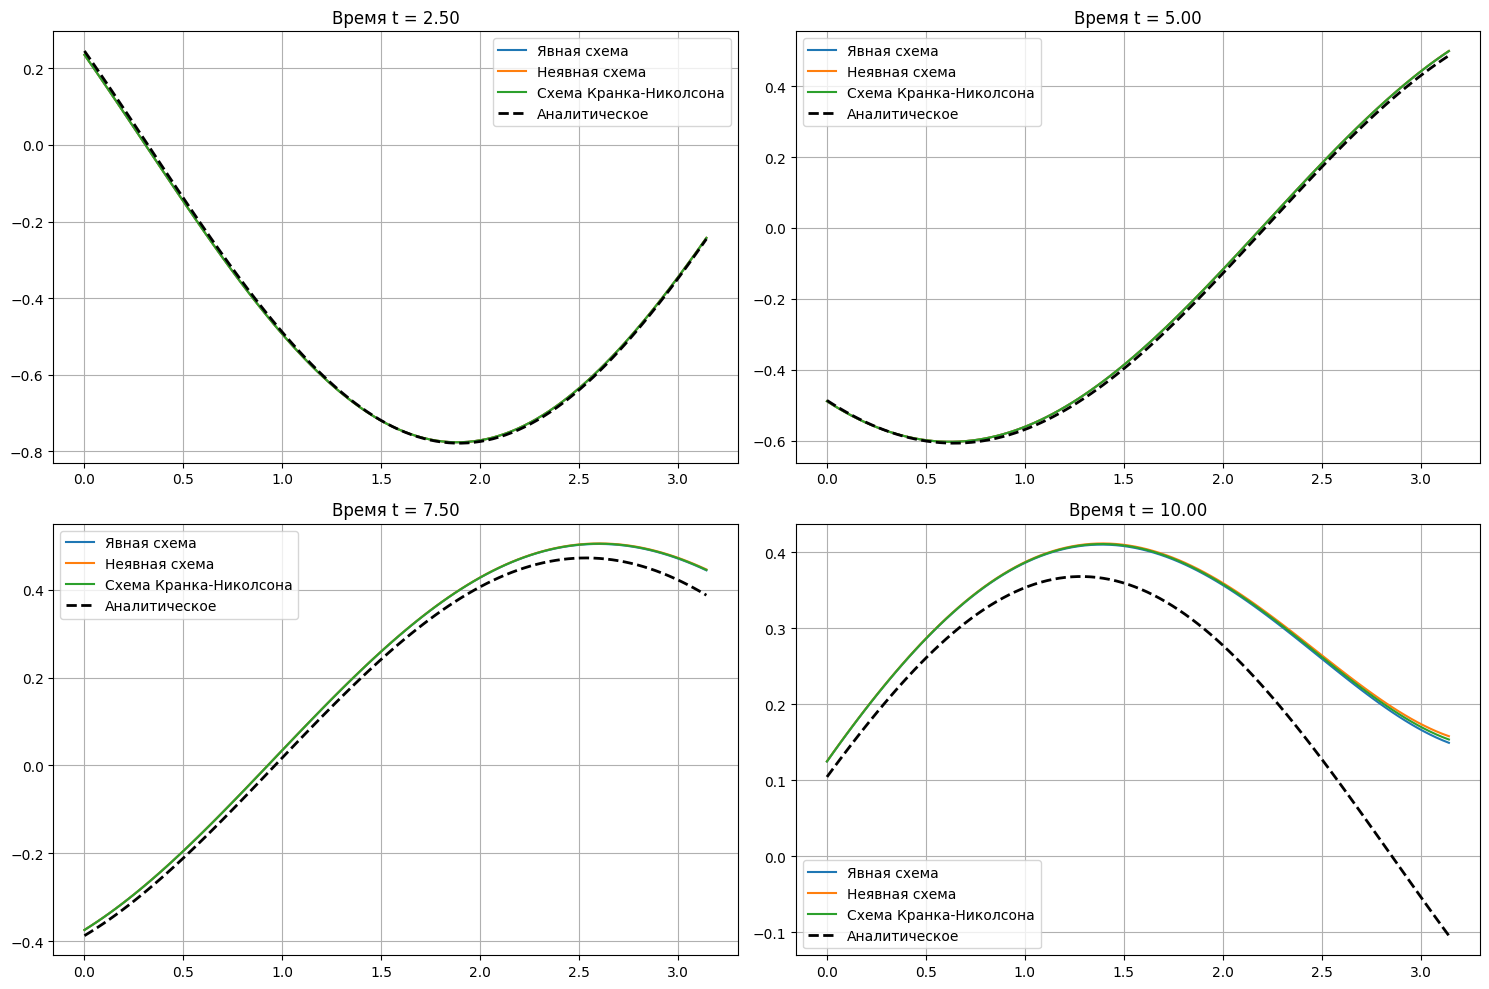

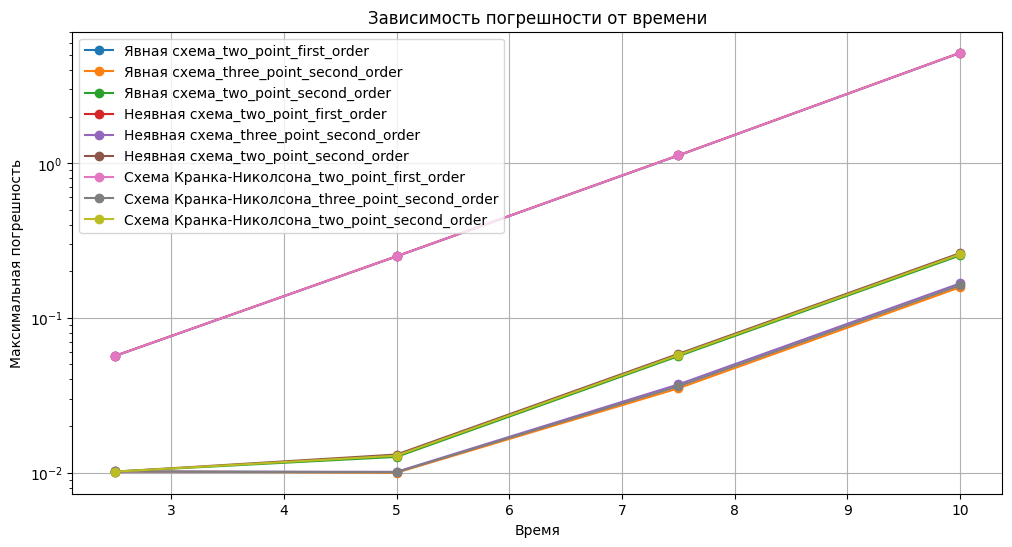


ТАБЛИЦА ПОГРЕШНОСТЕЙ

Явная схема_two_point_first_order:
Время	Погрешность
2.500	5.66e-02
5.000	2.50e-01
7.500	1.12e+00
10.000	5.16e+00

Явная схема_three_point_second_order:
Время	Погрешность
2.500	1.02e-02
5.000	9.98e-03
7.500	3.51e-02
10.000	1.58e-01

Явная схема_two_point_second_order:
Время	Погрешность
2.500	1.02e-02
5.000	1.26e-02
7.500	5.66e-02
10.000	2.54e-01

Неявная схема_two_point_first_order:
Время	Погрешность
2.500	5.67e-02
5.000	2.50e-01
7.500	1.12e+00
10.000	5.17e+00

Неявная схема_three_point_second_order:
Время	Погрешность
2.500	1.02e-02
5.000	1.01e-02
7.500	3.71e-02
10.000	1.67e-01

Неявная схема_two_point_second_order:
Время	Погрешность
2.500	1.01e-02
5.000	1.31e-02
7.500	5.85e-02
10.000	2.62e-01

Схема Кранка-Николсона_two_point_first_order:
Время	Погрешность
2.500	5.67e-02
5.000	2.50e-01
7.500	1.12e+00
10.000	5.17e+00

Схема Кранка-Николсона_three_point_second_order:
Время	Погрешность
2.500	1.02e-02
5.000	1.00e-02
7.500	3.61e-02
10.000	1.63e-01

Схема Кранка-Никол

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры задачи
a_coeff = 0.1
b_coeff = 0.5
c_coeff = 0
f = lambda x, t: 0

# Граничные условия: alpha * u_x + beta * u = gamma
alpha0 = 1
beta0 = -1
gamma0 = lambda t: -np.exp(-a_coeff * t) * (np.cos(b_coeff * t) + np.sin(b_coeff * t))

alphal = 1
betal = -1
gammal = lambda t: np.exp(-a_coeff * t) * (np.cos(b_coeff * t) + np.sin(b_coeff * t))

# Начальное условие
psi = lambda x: np.cos(x)

L = np.pi
T_max = 10

# Аналитическое решение для проверки
analytical_solution = lambda x, t: np.exp(-a_coeff * t) * np.cos(x + b_coeff * t)

L_count = 100
T_count = 100000

# Сеточные параметры
h = L / L_count
tau = T_max / T_count

X = np.linspace(0, L, L_count)
T = np.linspace(0, T_max, T_count)
print(X)
print(T)
def solve_parabolic(theta, boundary_approx_type='two_point_first_order'):
    if abs(theta) < 1e-12:
        sigma = a_coeff * tau / h ** 2
        if sigma > 0.5:
            print(f"ВНИМАНИЕ: Число Куранта σ = {sigma:.3f} > 0.5, схема может быть неустойчива!")
    
    u_num = np.zeros((len(T), len(X)))
    u_num[0, :] = psi(X)

    N = len(X) - 1

    for n in range(len(T) - 1):
        u_prev = u_num[n, :]
        u_next = np.zeros_like(u_prev)

        A = np.zeros(N + 1)
        B = np.zeros(N + 1)
        C = np.zeros(N + 1)
        D = np.zeros(N + 1)

        for i in range(1, N):
            coeff_left = -(a_coeff * theta / h**2) + (b_coeff * theta / (2 * h))
            coeff_center = 1 / tau + (2 * a_coeff * theta / h**2) - c_coeff * theta
            coeff_right = -(a_coeff * theta / h**2) - (b_coeff * theta / (2 * h))

            A[i] = coeff_left
            B[i] = coeff_center
            C[i] = coeff_right

            prev_left = (a_coeff * (1 - theta) / h**2) - (b_coeff * (1 - theta) / (2 * h))
            prev_center = 1 / tau - (2 * a_coeff * (1 - theta) / h**2) + c_coeff * (1 - theta)
            prev_right = (a_coeff * (1 - theta) / h**2) + (b_coeff * (1 - theta) / (2 * h))

            D[i] = (prev_left * u_prev[i - 1] +
                    prev_center * u_prev[i] +
                    prev_right * u_prev[i + 1] +
                    theta * f(X[i], T[n + 1]) + (1 - theta) * f(X[i], T[n]))

        t_next = T[n + 1]

        # Левое граничное условие
        if boundary_approx_type == 'two_point_first_order':
            A[0] = 0
            B[0] = beta0 - alpha0 / h
            C[0] = alpha0 / h
            D[0] = gamma0(t_next)

        elif boundary_approx_type == 'three_point_second_order':
            coeff0 = (-alpha0 / 2 / h) / C[1]
            A[0] = 0
            B[0] = (alpha0 * (-3/(2*h)) + beta0) - A[1] * coeff0
            C[0] = (alpha0 * (4/(2*h))) - B[1] * coeff0
            D[0] = gamma0(t_next) - D[1] * coeff0

        elif boundary_approx_type == 'two_point_second_order':
            A[0] = 0
            B[0] = (2 * a_coeff / h) + h / tau - c_coeff * h - beta0 / alpha0 * (2 * a_coeff - b_coeff * h) 
            C[0] = -2 * a_coeff / h
            D[0] = h / tau * u_prev[0] - gamma0(t_next) * (2 * a_coeff - b_coeff * h) / alpha0

        # Правое граничное условие
        if boundary_approx_type == 'two_point_first_order':
            A[N] = -alphal / h
            B[N] = alphal / h + betal
            C[N] = 0
            D[N] = gammal(t_next)

        elif boundary_approx_type == 'three_point_second_order':
            coeffl = (alphal / 2 / h) / A[N - 1]
            A[N] = -alphal * (4/(2*h)) - B[N - 1] * coeffl
            B[N] = alphal * (3/(2*h)) + betal - C[N - 1] * coeffl
            C[N] = 0
            D[N] = gammal(t_next) - D[N - 1] * coeffl

        elif boundary_approx_type == 'two_point_second_order':
            A[N] = -2 * a_coeff / h
            B[N] = 2 * a_coeff / h + h / tau - c_coeff * h + betal / alphal * (2 * a_coeff + b_coeff * h)
            C[N] = 0
            D[N] = h / tau * u_prev[N] + gammal(t_next) * (2 * a_coeff + b_coeff * h) / alphal

        # Метод прогонки
        alpha_prop = np.zeros(N + 1)
        beta_prop = np.zeros(N + 1)

        if abs(B[0]) < 1e-12:
            raise ValueError("Деление на ноль в методе прогонки")
        
        alpha_prop[0] = -C[0] / B[0]
        beta_prop[0] = D[0] / B[0]

        for i in range(1, N + 1):
            denominator = B[i] + A[i] * alpha_prop[i - 1]
            if abs(denominator) < 1e-12:
                raise ValueError("Деление на ноль в методе прогонки")
            if i < N:
                alpha_prop[i] = -C[i] / denominator
            beta_prop[i] = (D[i] - A[i] * beta_prop[i - 1]) / denominator

        u_next[N] = beta_prop[N]

        for i in range(N - 1, -1, -1):
            u_next[i] = alpha_prop[i] * u_next[i + 1] + beta_prop[i]

        u_num[n + 1, :] = u_next

    return u_num

def solve_parabolic_explicit(approx_type='two_point_first_order'):
    if abs(theta) < 1e-12:
        sigma = a_coeff * tau / h ** 2
        if sigma > 0.5:
            print(f"ВНИМАНИЕ: Число Куранта σ = {sigma:.3f} > 0.5, схема может быть неустойчива!")
    
    u_num = np.zeros((len(T), len(X)))
    u_num[0, :] = psi(X)

    N = len(X) - 1
    
    for n in range(len(T) - 1):
        t = T[n]
        u_prev = u_num[n]
        u_next = np.zeros(N + 1)
        
        for i in range(1, N):
            u_next[i] = u_prev[i - 1] * ((a_coeff * tau / h ** 2) - (b_coeff * tau / (2 * h))) + \
                        u_prev[i] * (1 - 2 * a_coeff * tau / h ** 2) + c_coeff * tau +\
                        u_prev[i + 1] * ((a_coeff * tau / h ** 2) + (b_coeff * tau / (2 * h))) + \
                        tau * f(X[i], t)
        t_next = T[n + 1]
        if approx_type == 'two_point_first_order':
            u_next[0] = (gamma0(t_next) - (alpha0 / h) * u_next[1]) / (beta0 - (alpha0 / h))
            u_next[N] = (gammal(t_next) + (alphal / h) * u_next[N - 1]) / (betal + (alphal / h))
        
        elif approx_type == 'three_point_second_order':
            u_next[0] = (gamma0(t_next) - u_next[1] * (4 * alpha0 / 2 / h) + u_next[2] * (alpha0 / 2 / h )) / \
                        ((-3 * alpha0 / 2 / h) + beta0)
            u_next[N] = (gammal(t_next) - u_next[N - 2] * (alphal / 2 / h) - u_next[N - 1] * (-4 * alphal / 2 / h)) / \
                        ((3 * alphal / 2 / h) + betal)
        
        elif approx_type == 'two_point_second_order':
            b0 = (2 * a_coeff / h) + h / tau - c_coeff * h - beta0 / alpha0 * (2 * a_coeff - b_coeff * h)
            c0 = -2 * a_coeff / h
            d0 = h / tau * u_prev[0] - gamma0(t_next) * (2 * a_coeff - b_coeff * h) / alpha0
            
            al = -2 * a_coeff / h
            bl = 2 * a_coeff / h + h / tau - c_coeff * h + betal / alphal * (2 * a_coeff + b_coeff * h)
            dl = h / tau * u_prev[N] + gammal(t_next) * (2 * a_coeff + b_coeff * h) / alphal
            
            u_next[0] = (d0 - c0 * u_next[1]) / b0
            u_next[N] = (dl - al * u_next[N - 1]) / bl 
                        
        u_num[n + 1, :] = u_next

    return u_num



schemes = [
    (0.0, 'Явная схема'),
    (1.0, 'Неявная схема'),
    (0.5, 'Схема Кранка-Николсона')
]

boundary_approximations = [
    'two_point_first_order',
    'three_point_second_order', 
    'two_point_second_order'
]

results = {}
for theta, scheme_name in schemes:
    for approx_type in boundary_approximations:
        key = f"{scheme_name}_{approx_type}"
        print(f"Вычисление: {key}")
        try:
            if theta < 1e-12:
                u_num = solve_parabolic_explicit(approx_type)
            else:
                u_num = solve_parabolic(theta, approx_type)
            
            errors = {}
            time_indices = [len(T) // 4, len(T) // 2, 3 * len(T) // 4, len(T) - 1]
            
            for idx in time_indices:
                if idx < len(u_num):
                    u_analytical = analytical_solution(X, T[idx])
                    error = np.abs(u_num[idx, :] - u_analytical)
                    errors[T[idx]] = np.max(error)
            
            results[key] = {
                'solution': u_num,
                'errors': errors
            }
        except Exception as e:
            print(f"Ошибка при вычислении {key}: {e}")


def plot_results(results, X, T):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    time_indices = [len(T) // 4, len(T) // 2, 3 * len(T) // 4, len(T) - 1]

    for idx, time_idx in enumerate(time_indices[:4]):
        ax = axes[idx // 2, idx % 2]
        t_val = T[time_idx]

        for scheme_name in ['Явная схема_two_point_second_order',
                          'Неявная схема_two_point_second_order', 
                          'Схема Кранка-Николсона_two_point_second_order']:
            if scheme_name in results:
                u_num = results[scheme_name]['solution']
                ax.plot(X, u_num[time_idx, :], label=scheme_name.split('_')[0])

        u_analytical = analytical_solution(X, t_val)
        ax.plot(X, u_analytical, 'k--', linewidth=2, label='Аналитическое')
        ax.set_title(f'Время t = {t_val:.2f}')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    for key, result in results.items():
        times = list(result['errors'].keys())
        errors = list(result['errors'].values())
        plt.semilogy(times, errors, 'o-', label=key)

    plt.xlabel('Время')
    plt.ylabel('Максимальная погрешность')
    plt.title('Зависимость погрешности от времени')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    plot_results(results, X, T)

    print("\n" + "=" * 60)
    print("ТАБЛИЦА ПОГРЕШНОСТЕЙ")
    print("=" * 60)

    for scheme_name in results.keys():
        print(f"\n{scheme_name}:")
        print("Время\tПогрешность")
        for time, error in results[scheme_name]['errors'].items():
            print(f"{time:.3f}\t{error:.2e}")